In [4]:
# load dependencies'
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn' surpresses warnings at spatial distribution
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats
import numpy as np
import math
import plotly.express as px
import sklearn.linear_model
import sklearn.neighbors
from sklearn.metrics import mean_squared_error
from math import sqrt

import sys
import os
sys.path.append('..')

from envirocar import TrackAPI, DownloadClient, BboxSelector, ECConfig#, Inspection

# pandas show all columns of table instead of restricted#
pd.set_option('display.max_columns', None)

# create an initial but optional config and an api client
config = ECConfig()
track_api = TrackAPI(api_client=DownloadClient(config=config))
#inspect=Inspection()


def sum_missing_values(df):
    listCol =[] 
    rowCount = df.shape[0]
    for column in df:
        sumColumn = df[column].isna().sum()
        percentNA = sumColumn/rowCount*100    
        if percentNA <= 80:
            listCol.append({'column':column ,'missing_values': sumColumn, 'missing_values(%)': percentNA})
    listCol = pd.DataFrame(listCol).sort_values(by='missing_values', ascending=False).reset_index(drop=True)
    return listCol


def get_classified_correlations(df, method):
    allCoeffs=[]
    correlationsMatrixAll = df.corr(method=method)
    for column in correlationsMatrixAll:
        for i in correlationsMatrixAll[column].index:
            df = correlationsMatrixAll.at[i, column]
            if df != 1.0:
                allCoeffs.append({'column':column, 'index':i, 'coefficient':df })
 
    correlationsMatrix = correlationsMatrixAll.where(np.tril(np.ones(correlationsMatrixAll.shape)).astype(np.bool))
    
    very_strong=[]
    strong=[]
    moderate=[]
    weak=[]   
    for column in correlationsMatrix:
        for i in correlationsMatrix[column].index:
            df = correlationsMatrix.at[i, column]
            if df >= 0.8 and df < 1.0 or df <= -0.8 and df > -1.0:
                very_strong.append({'column':column, 'index':i, 'coefficient':df })#   
            if df >= 0.6 and df < 0.8 or df <= -0.6 and df > -0.8:
                strong.append({'column':column, 'index':i, 'coefficient':df })
            if df >= 0.4 and df < 0.6 or df <= -0.4 and df > -0.6:
                moderate.append({'column':column, 'index':i, 'coefficient':df })
            if df < 0.4 and df > -0.4:
                weak.append({'column':column, 'index':i, 'coefficient':df })
    
    very_strong = pd.DataFrame(very_strong).sort_values(by='coefficient', ascending=False).reset_index(drop=True)
    strong = pd.DataFrame(strong).sort_values(by='coefficient', ascending=False).reset_index(drop=True)
    moderate = pd.DataFrame(moderate).sort_values(by='coefficient', ascending=False).reset_index(drop=True)
    weak=pd.DataFrame(weak).sort_values(by='coefficient', ascending=False).reset_index(drop=True)
    allCoeffs= pd.DataFrame(allCoeffs).sort_values(by='coefficient', ascending=False).reset_index(drop=True)

    return allCoeffs, very_strong, strong, moderate, weak 


def flag_outlier_in_sample(df, listOfVariableNames, dropOutlierColumn=False, setOutlierToNan=False):
    '''
        Aim: Find outlier with regard to the sample's distribution 
        
        Input: Geodataframa
        
        Output: Geodataframe with added column which values are '1' 
                when a certain value of a variable in the list is considered to be an outlier regarding the samples's distribution
    '''
    df['outlier_in_sample'] = 0
    for variable in listOfVariableNames:
        variableName='outlier_in_sample_'+ variable
        df[variableName] = 0
        Q1 = df[variable].quantile(0.25)
        Q3 = df[variable].quantile(0.75)
        IQR = Q3 - Q1
        low_lim = Q1 - 1.5 * IQR 
        up_lim = Q3 + 1.5 * IQR  
        df.loc[df[variable] < low_lim, variableName] = 1
        df.loc[df[variable] > up_lim, variableName] = 1
        df.loc[df[variable] < low_lim, 'outlier_in_sample'] = 1
        df.loc[df[variable] > up_lim, 'outlier_in_sample'] = 1
        print(variableName, (df[variableName].values == 1).sum())
        
        if setOutlierToNan == True:
            df.loc[df[variableName] == 1 , variable] = np.nan
        
        if dropOutlierColumn == True:
            df.drop([variableName], axis=1, inplace=True)
            
    outlier = (df['outlier_in_sample'].values == 1).sum()
    print('Flagged outlier in sample: ', outlier)
    return df


def flag_outlier_in_track(df, listOfVariableNames, dropLimits=True, dropOutlierColumn=False, setOutlierToNan=False):

    
    def low_limit(x):
            q1 = x.quantile(0.25)
            q3 = x.quantile(0.75)
            iqr = q3 - q1
            lower_limit = q1 - 1.5 * iqr
            return lower_limit

    def upper_limit(x):
            q1 = x.quantile(0.25)
            q3 = x.quantile(0.75)
            iqr = q3 - q1
            upper_limit = q3 + 1.5 * iqr
            return upper_limit
    
    df['outlier_in_track_all'] = 0
    for variable in listOfVariableNames:
            lowName = 'track_lowerLimit_' + variable
            upName = 'track_upperLimit_' + variable
            df_1 = df.groupby(['track.id'])
            df[lowName] = df_1[variable].transform(low_limit)
            df[upName] = df_1[variable].transform(upper_limit)
            df.loc[df[upName] < df[variable], "outlier_in_track_all"] = 1 
            df.loc[df[lowName] > df[variable], "outlier_in_track_all"] = 1 
            variableName='outlier_in_track_'+ variable
            df[variableName] = 0
            df.loc[df[upName] < df[variable], variableName] = 1 
            df.loc[df[lowName] > df[variable], variableName] = 1
            print(variableName, (df[variableName].values == 1).sum())
            
            if setOutlierToNan == True:
                df.loc[df[variableName] == 1 , variable] = np.nan
                      
            if dropLimits == True:
                df.drop([upName, lowName], axis=1, inplace=True)
            
            if dropOutlierColumn == True:
                df.drop([variableName], axis=1, inplace=True)
    
    outlier = (df['outlier_in_track_all'].values == 1).sum()
    print('Rows which contain outliers in tracks  (there may be multiple outlier in a single row) : ',outlier)
    return df


bbox = BboxSelector([
    7.554130554199218, # min_x
    51.95590322041212, # min_y
    7.590351104736328, # max_x
    51.97874790276371  # max_y
])


# issue a query
track_df = track_api.get_tracks(bbox=bbox, num_results=40) 

track_df.drop_duplicates(subset=['geometry', 'Engine Load.value', 'Calculated MAF.value',
       'Speed.value', 'CO2.value', 'Intake Pressure.value', 'Rpm.value',
       'Intake Temperature.value', 'Consumption (GPS-based).value',
       'GPS Altitude.value', 'Throttle Position.value', 'GPS Bearing.value',
       'Consumption.value', 'GPS Accuracy.value',
       'CO2 Emission (GPS-based).value', 'GPS Speed.value', 
       'track.length', 'track.begin', 'track.end', 'sensor.type',
       'sensor.engineDisplacement', 'sensor.model', 'sensor.id',
       'sensor.fuelType', 'sensor.constructionYear', 'sensor.manufacturer',
       'track.appVersion', 'track.touVersion', 'GPS HDOP.value',
       'GPS PDOP.value', 'GPS VDOP.value'], inplace=True, keep='last')


In [6]:
track_df.head()

,id,time,geometry,Engine Load.value,Engine Load.unit,Calculated MAF.value,Calculated MAF.unit,Speed.value,Speed.unit,CO2.value,CO2.unit,Intake Pressure.value,Intake Pressure.unit,Rpm.value,Rpm.unit,Intake Temperature.value,Intake Temperature.unit,Consumption (GPS-based).value,Consumption (GPS-based).unit,GPS Altitude.value,GPS Altitude.unit,Throttle Position.value,Throttle Position.unit,GPS Bearing.value,GPS Bearing.unit,Consumption.value,Consumption.unit,GPS Accuracy.value,GPS Accuracy.unit,CO2 Emission (GPS-based).value,CO2 Emission (GPS-based).unit,GPS Speed.value,GPS Speed.unit,track.id,track.length,track.begin,track.end,sensor.type,sensor.engineDisplacement,sensor.model,sensor.id,sensor.fuelType,sensor.constructionYear,sensor.manufacturer,track.appVersion,track.touVersion,GPS HDOP.value,GPS HDOP.unit,GPS PDOP.value,GPS PDOP.unit,GPS VDOP.value,GPS VDOP.unit,MAF.value,MAF.unit,O2 Lambda Voltage ER.value,O2 Lambda Voltage ER.unit,O2 Lambda Voltage.value,O2 Lambda Voltage.unit
0,5f0ef89c00375c5a2641ef86,2020-07-15T12:37:03,POINT (7.57939 51.96766),30.459892,%,3.113889,g/s,15.978930,km/h,2.405470,kg/h,29.667201,kPa,748.952252,u/min,26.000000,c,0.936199,l/h,115.671012,m,13.000000,%,136.590329,deg,1.023604,l/h,6.000000,%,2.200068,kg/h,17.502660,km/h,5f0ef89c00375c5a2641ef84,0.665466,2020-07-15T12:37:03Z,2020-07-15T12:38:25Z,car,1699,A 170,559e22c2e4b07207d8977998,gasoline,2004,Mercedes Benz,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5f0ef89c00375c5a2641ef88,2020-07-15T12:37:09,POINT (7.57955 51.96757),49.230105,%,9.778811,g/s,11.134565,km/h,7.554102,kg/h,47.232322,kPa,1475.604745,u/min,25.652838,c,0.937457,l/h,115.280639,m,16.642229,%,134.479803,deg,3.214511,l/h,6.000000,%,2.203025,kg/h,10.324164,km/h,5f0ef89c00375c5a2641ef84,0.665466,2020-07-15T12:37:03Z,2020-07-15T12:38:25Z,car,1699,A 170,559e22c2e4b07207d8977998,gasoline,2004,Mercedes Benz,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5f0ef89c00375c5a2641ef89,2020-07-15T12:37:14,POINT (7.57988 51.96740),78.649652,%,25.066406,g/s,33.976330,km/h,19.363722,kg/h,74.040426,kPa,2397.395931,u/min,23.728013,c,5.102906,l/h,114.613231,m,23.862069,%,123.313954,deg,8.239881,l/h,6.193485,%,11.991830,kg/h,30.967132,km/h,5f0ef89c00375c5a2641ef84,0.665466,2020-07-15T12:37:03Z,2020-07-15T12:38:25Z,car,1699,A 170,559e22c2e4b07207d8977998,gasoline,2004,Mercedes Benz,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5f0ef89c00375c5a2641ef8a,2020-07-15T12:37:19,POINT (7.58049 51.96715),31.200400,%,7.419664,g/s,39.000000,km/h,5.731668,kg/h,30.075758,kPa,1748.565672,u/min,24.000000,c,2.280491,l/h,113.835218,m,15.351261,%,125.035780,deg,2.439007,l/h,6.000000,%,5.359154,kg/h,36.898346,km/h,5f0ef89c00375c5a2641ef84,0.665466,2020-07-15T12:37:03Z,2020-07-15T12:38:25Z,car,1699,A 170,559e22c2e4b07207d8977998,gasoline,2004,Mercedes Benz,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5f0ef89c00375c5a2641ef8b,2020-07-15T12:37:24,POINT (7.58107 51.96682),29.735773,%,3.106679,g/s,34.321667,km/h,2.399900,kg/h,29.000000,kPa,761.854074,u/min,25.000000,c,0.946257,l/h,113.502384,m,13.000000,%,133.482068,deg,1.021234,l/h,7.489919,%,2.223704,kg/h,34.447545,km/h,5f0ef89c00375c5a2641ef84,0.665466,2020-07-15T12:37:03Z,2020-07-15T12:38:25Z,car,1699,A 170,559e22c2e4b07207d8977998,gasoline,2004,Mercedes Benz,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Take only numerical variables

In [10]:
track_df_numeric = track_df.select_dtypes(['float64']).copy()
track_df_numeric.head()

,Engine Load.value,Calculated MAF.value,Speed.value,CO2.value,Intake Pressure.value,Rpm.value,Intake Temperature.value,Consumption (GPS-based).value,GPS Altitude.value,Throttle Position.value,GPS Bearing.value,Consumption.value,GPS Accuracy.value,CO2 Emission (GPS-based).value,GPS Speed.value,track.length,GPS HDOP.value,GPS PDOP.value,GPS VDOP.value,MAF.value,O2 Lambda Voltage ER.value,O2 Lambda Voltage.value
0,30.459892,3.113889,15.978930,2.405470,29.667201,748.952252,26.000000,0.936199,115.671012,13.000000,136.590329,1.023604,6.000000,2.200068,17.502660,0.665466,NaN,NaN,NaN,NaN,NaN,NaN
1,49.230105,9.778811,11.134565,7.554102,47.232322,1475.604745,25.652838,0.937457,115.280639,16.642229,134.479803,3.214511,6.000000,2.203025,10.324164,0.665466,NaN,NaN,NaN,NaN,NaN,NaN
2,78.649652,25.066406,33.976330,19.363722,74.040426,2397.395931,23.728013,5.102906,114.613231,23.862069,123.313954,8.239881,6.193485,11.991830,30.967132,0.665466,NaN,NaN,NaN,NaN,NaN,NaN
3,31.200400,7.419664,39.000000,5.731668,30.075758,1748.565672,24.000000,2.280491,113.835218,15.351261,125.035780,2.439007,6.000000,5.359154,36.898346,0.665466,NaN,NaN,NaN,NaN,NaN,NaN
4,29.735773,3.106679,34.321667,2.399900,29.000000,761.854074,25.000000,0.946257,113.502384,13.000000,133.482068,1.021234,7.489919,2.223704,34.447545,0.665466,NaN,NaN,NaN,NaN,NaN,NaN


Inspect missing values to choose a variable which has many missing values
For this variable we will then try to impute the missing values we will try to impute CO2 Emission (GPS-based).value

In [11]:
missingValues=sum_missing_values(track_df_numeric)
missingValues

,column,missing_values,missing_values(%)
0,Calculated MAF.value,2759,27.908153
1,Consumption.value,2047,20.706049
2,CO2.value,2047,20.706049
3,Intake Pressure.value,1506,15.233664
4,Throttle Position.value,923,9.336435
5,Engine Load.value,821,8.304673
6,GPS HDOP.value,672,6.797491
7,GPS PDOP.value,672,6.797491
8,GPS VDOP.value,672,6.797491
9,Rpm.value,425,4.299009


#### Spearman correlation

Just to get an impression, chose the variable which has the strongest non-parametric relationship with CO2 Emission (GPS-based).value by applying a spearman correlation.
Here it seems to be he Speed.value so we will try to impute CO2 Emission (GPS-based).value based on Speed.value

In [12]:
allCoeffs, very_strong, strong, moderate, weak = get_classified_correlations(track_df_numeric, 'spearman')
allCoeffs.loc[(allCoeffs['column'] == 'Consumption (GPS-based).value')]

,column,index,coefficient
61,Consumption (GPS-based).value,Speed.value,0.646259
66,Consumption (GPS-based).value,GPS Speed.value,0.630313
70,Consumption (GPS-based).value,Rpm.value,0.627127
85,Consumption (GPS-based).value,Calculated MAF.value,0.542831
87,Consumption (GPS-based).value,CO2.value,0.542831
91,Consumption (GPS-based).value,Consumption.value,0.542831
100,Consumption (GPS-based).value,Throttle Position.value,0.513786
149,Consumption (GPS-based).value,Engine Load.value,0.228733
165,Consumption (GPS-based).value,Intake Pressure.value,0.183093
230,Consumption (GPS-based).value,GPS Bearing.value,0.018950


#### Outlier
Remove outlier from the variables

In [14]:
relation = track_df[["track.id","Speed.value", "CO2 Emission (GPS-based).value"]]
flag_outlier_in_sample(relation, ['CO2 Emission (GPS-based).value'], dropOutlierColumn=True, setOutlierToNan=True)
flag_outlier_in_track(relation, ['CO2 Emission (GPS-based).value'], dropLimits=True, dropOutlierColumn=True, setOutlierToNan=True)
relation

outlier_in_sample_CO2 Emission (GPS-based).value 30
Flagged outlier in sample:  30
outlier_in_track_CO2 Emission (GPS-based).value 17
Rows which contain outliers in tracks  (there may be multiple outlier in a single row) :  17


,track.id,Speed.value,CO2 Emission (GPS-based).value,outlier_in_sample,outlier_in_track_all
0,5f0ef89c00375c5a2641ef84,15.978930,2.200068,0,0
1,5f0ef89c00375c5a2641ef84,11.134565,2.203025,0,0
2,5f0ef89c00375c5a2641ef84,33.976330,11.991830,0,0
3,5f0ef89c00375c5a2641ef84,39.000000,5.359154,0,0
4,5f0ef89c00375c5a2641ef84,34.321667,2.223704,0,0
...,...,...,...,...,...
183,57c7cdfae4b0f05fc1c86833,19.129159,NaN,0,0
184,57c7cdfae4b0f05fc1c86833,22.405573,NaN,0,0
185,57c7cdfae4b0f05fc1c86833,28.234810,NaN,0,0
186,57c7cdfae4b0f05fc1c86833,42.380618,NaN,0,0


#### Prepare the data 
To train the model we need some complete data. Therefore we delete all rows without a valid value.

In [15]:
# drop all rows which contain NaN and reset the index as we look at the whole sample, not on groups here
relation2 = relation.dropna()
relation2.reset_index(drop=True, inplace=True)
relation2

,track.id,Speed.value,CO2 Emission (GPS-based).value,outlier_in_sample,outlier_in_track_all
0,5f0ef89c00375c5a2641ef84,15.978930,2.200068,0,0
1,5f0ef89c00375c5a2641ef84,11.134565,2.203025,0,0
2,5f0ef89c00375c5a2641ef84,33.976330,11.991830,0,0
3,5f0ef89c00375c5a2641ef84,39.000000,5.359154,0,0
4,5f0ef89c00375c5a2641ef84,34.321667,2.223704,0,0
...,...,...,...,...,...
593,5eeb4acdd6e3cf256ba12a68,0.000000,3.696637,0,0
594,5eeb4acdd6e3cf256ba12a68,8.146634,1.807885,0,0
595,5eeb4acdd6e3cf256ba12a68,4.000000,2.166901,0,0
596,5eeb4acdd6e3cf256ba12a68,0.000000,2.158704,0,0


As we can see in the plot, there may be a linear relationship, however 
the line is far away from describing the relationship very well
Still, we will have a look how good the linear regression predicts CO2 Emissions

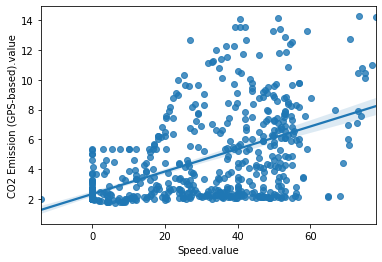

In [16]:
sns.regplot(x=relation2["Speed.value"], y=relation2["CO2 Emission (GPS-based).value"])

#### Prepare variables

In [17]:
X = np.c_[relation2["Speed.value"]]
y = np.c_[relation2["CO2 Emission (GPS-based).value"]]

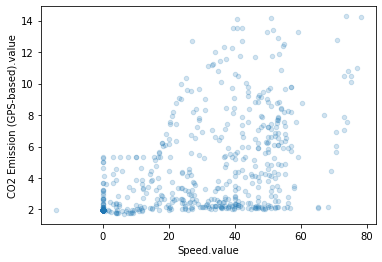

In [18]:
relation2.plot(kind='scatter', x = "Speed.value", y = "CO2 Emission (GPS-based).value", alpha=0.2 )

### Median

In [19]:
# impute nan with median
X_impute= np.c_[relation["CO2 Emission (GPS-based).value"]]
X_impute
import sklearn.impute
imputer=sklearn.impute.SimpleImputer(strategy='median')
imputer.fit(y)
X_impute

array([[ 2.20006789],
       [ 2.20302462],
       [11.99182982],
       ...,
       [        nan],
       [        nan],
       [        nan]])

In [20]:
imputedCO2Emission=imputer.transform(X_impute)
imputedCO2Emission

array([[ 2.20006789],
       [ 2.20302462],
       [11.99182982],
       ...,
       [ 2.96543137],
       [ 2.96543137],
       [ 2.96543137]])

### Linear Regression

In [24]:
# linear regression
modelLinear= sklearn.linear_model.LinearRegression()
modelLinear.fit(X, y)
prepareData = np.c_[relation2["Speed.value"]]
y_predicted= modelLinear.predict(prepareData)

#### Check the rmse
We have an rmse of ~ 2.5, this means we have typical prediction error of 2.5

In [25]:
mse = mean_squared_error(y, y_predicted)
rmse = sqrt(mse)
rmse

2.543442421154638

###  K-nearest Neighbor

In [26]:
modelNeighbor = sklearn.neighbors.KNeighborsRegressor(n_neighbors=2)
modelNeighbor.fit(X,y)
y_predict_n=modelNeighbor.predict(prepareData)

#### Check the rmse
Still not perfect but better: we have here a typical error of ~ 1.876.
We will need more sophisticated methods to impute missing values.

In [27]:
rmse_n = sqrt(mean_squared_error(y, y_predict_n))
rmse_n

1.8756612993704311